In [3]:
#storing and manipulating data
import pandas as pd
import numpy as np

#plotting
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

#natural language tool kit
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

#RoBERTa Model from Hugging Face
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

## Load / Data Wrangling for Sentiment Analysis

In [4]:
data = pd.read_csv('Reviews.csv', usecols=['Score', 'Summary', 'Text'])
print(data.shape)
display(data.head())

(568454, 3)


,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


**Sampling Approach**

In [5]:
#the overall dataset is too large so we will downsample the data to 500 examples for analysis 
sample_data = data.sample(500)

#combine the summary / heading and text description
sample_data['review_text'] = sample_data['Summary'] + ' ' +  sample_data['Text']

#we can also remove the previous original columns
sample_data.drop(['Summary', 'Text'], axis = 1, inplace = True)
    
sample_data = sample_data.reset_index()
sample_data.drop(['index'], axis = 1, inplace=True)
sample_data.head()

,Score,review_text
0,3,Salt I was a little disappointed with this pro...
1,4,Good Communications I rec'd different flavor o...
2,5,Great product - expensive to buy on Amazon Thi...
3,3,A bit disappointing. They provide platforms fo...
4,5,"Delicious!! This coffee is amazing, it is abso..."


In [6]:
# Let's use a previews sample obtained
df = pd.read_csv('amazon_reviews_dataset_500.csv')
df.head()

,Score,review_text
0,1,Sprayed orange grease all over the inside of t...
1,3,Had higher expectations It is a naturally swee...
2,5,Everything is as it should be I ordered these ...
3,5,So Happy I found this; Product is Fabulous I d...
4,5,"Great tea, very satisfying Nice mellow tea for..."


## Exploratory Data Analysis (EDA)

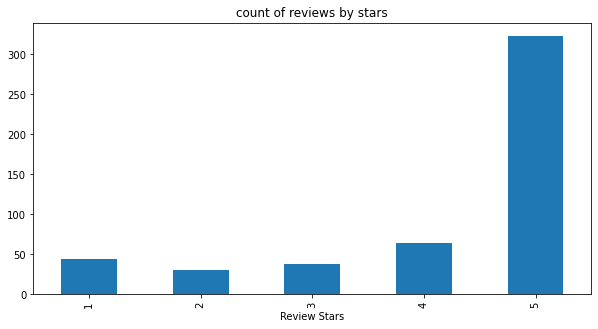

In [7]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = df['Score'].value_counts().sort_index().plot(kind = 'bar')
ax.set_xlabel('Review Stars')
plt.title('count of reviews by stars')
plt.show()

The overall distribution of reviews seems to be more positive and then there is a slight spike in the 1 star negetive reviews, so data is mostly very polar.

## Basic NLTK

In [8]:
example = df['review_text'][50]
print(example)

Great Price, Not what I was hoping for though. There's the original Tang. There's the fruition Tang that was around from 2008 to 2010, which had extra vitamins (B,D,A, etc.) and replaced half the sugar with zero calorie sweeteners. But tang has gone back to a flavor more similar to the original with full sugar content. I was hoping for the fruition version, which other reviewers received.


In [9]:
#use the nltk's word tokenizer to smartly split the sentence into tokens which can be used to understand the language by the computer
tokens = nltk.word_tokenize(example)
tokens[:8]

['Great', 'Price', ',', 'Not', 'what', 'I', 'was', 'hoping']

In [10]:
#find the part of speech for each of the token words with nltk each word will get a part of speech value associated with them 
#and they are represented with codes like NN is for singular nouns
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Great', 'NNP'),
 ('Price', 'NNP'),
 (',', ','),
 ('Not', 'RB'),
 ('what', 'WP'),
 ('I', 'PRP'),
 ('was', 'VBD'),
 ('hoping', 'VBG'),
 ('for', 'IN'),
 ('though', 'IN')]

In [11]:
#we can group these tagged values into chunks of tags entities
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  (GPE Great/NNP)
  Price/NNP
  ,/,
  Not/RB
  what/WP
  I/PRP
  was/VBD
  hoping/VBG
  for/IN
  though/IN
  ./.
  There/EX
  's/VBZ
  the/DT
  original/JJ
  (PERSON Tang/NNP)
  ./.
  There/EX
  's/VBZ
  the/DT
  fruition/NN
  (PERSON Tang/NNP)
  that/WDT
  was/VBD
  around/IN
  from/IN
  2008/CD
  to/TO
  2010/CD
  ,/,
  which/WDT
  had/VBD
  extra/JJ
  vitamins/NNS
  (/(
  B/NNP
  ,/,
  (GPE D/NNP)
  ,/,
  A/NNP
  ,/,
  etc/FW
  ./.
  )/)
  and/CC
  replaced/VBD
  half/PDT
  the/DT
  sugar/NN
  with/IN
  zero/CD
  calorie/NN
  sweeteners/NNS
  ./.
  But/CC
  tang/NN
  has/VBZ
  gone/VBN
  back/RB
  to/TO
  a/DT
  flavor/NN
  more/JJR
  similar/JJ
  to/TO
  the/DT
  original/JJ
  with/IN
  full/JJ
  sugar/NN
  content/NN
  ./.
  I/PRP
  was/VBD
  hoping/VBG
  for/IN
  the/DT
  fruition/NN
  version/NN
  ,/,
  which/WDT
  other/JJ
  reviewers/NNS
  received/VBD
  ./.)


## VADER Sentiment Scoring

**VADER**: Valence Aware Dictonary and sEntiment Reasoner

We'll use NLTK's `SentimentInetensityAnalyzer` to get the negetive (neg), neutral (neu) and positive (pos) scores for the text.

**Approach**:
- Uses a "bag of words" approach
- Stop words are removed - words like (is, the, am, etc.)
- each word is scored and combined to a total score to get a overall sentiment score of text.

**Limitations**:
- does not account for relationships between words, which is an important part of human speech.

In [13]:
sia = SentimentIntensityAnalyzer()

In [14]:
#example of using sentiment analyzer on a positive sentence
sia.polarity_scores('I am so happy! Today is such a great day and I love ML.')

{'neg': 0.0, 'neu': 0.389, 'pos': 0.611, 'compound': 0.9272}

In [15]:
#on the other hand sentiment analyzer on a negetive example
sia.polarity_scores('This is the worst thing ever, I would never buy something this bad.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.8491}

In [16]:
#It can also work well on some confusing sentences - to give a overall slightly positive rating for this sentence.
sia.polarity_scores('hey, I hate you, just kidding you know I love you!')

{'neg': 0.237, 'neu': 0.385, 'pos': 0.378, 'compound': 0.2942}

**Observations**:

We are successfully able to identify the overall sentiment of the text with compound score which varies between 1 (for positive) and -1 (for negetive).

Now we can try to apply this to our reviews dataset.

In [17]:
#Run Polarity Score on the entire dataset
res = {}
for idx, row in df.iterrows():
    text = row['review_text']
    res[idx] = sia.polarity_scores(text)

In [18]:
vaders = pd.DataFrame(res).T
vaders = vaders.merge(df, how = 'left', right_index=True, left_index=True)
vaders.head()

,neg,neu,pos,compound,Score,review_text
0,0.070,0.800,0.130,0.8422,1,Sprayed orange grease all over the inside of t...
1,0.082,0.727,0.192,0.7655,3,Had higher expectations It is a naturally swee...
2,0.025,0.807,0.168,0.9238,5,Everything is as it should be I ordered these ...
3,0.092,0.693,0.214,0.9061,5,So Happy I found this; Product is Fabulous I d...
4,0.000,0.497,0.503,0.9692,5,"Great tea, very satisfying Nice mellow tea for..."


**How to measure effectiveness?**

One way to see if our model is working as expected or not, is to check an assumption.

We can assume that what our model classifies as more positive has higher star review and the reviews predicted to be more negetive have a lower star review associated with them.

If this is true then, we can rely on text sentiment analysis to tell us how our users feel about products overall.

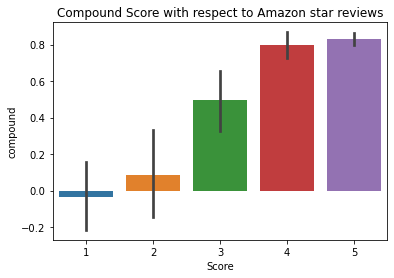

In [19]:
# Plot Vaders results
sns.barplot(data=vaders, x='Score', y='compound')
plt.title('Compound Score with respect to Amazon star reviews')
plt.show()

**Observation:** We can see that the assumptions seems to be right as higher star reviews have a high compound score associated with them.

**Taking a look at each component of sentiment analysis (pos, neu and neg) with respect to star reviews**

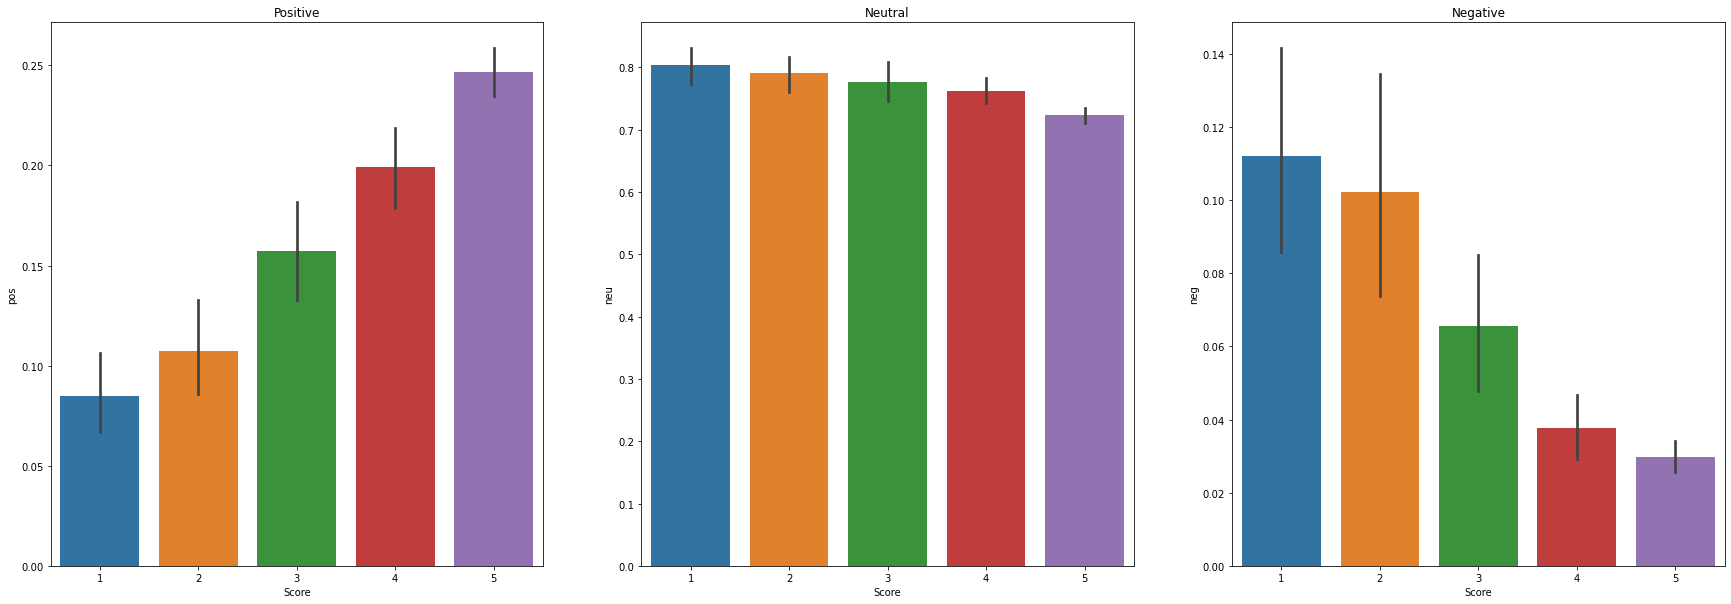

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.show()

**Observations:**
- postivity score is higher as star reviews are higher star reviews
- neural scores do not vary much accross different star reviews
- negativity score decreases with higher star reviews

**So we can conclude that our sentiment analysis score does relate to the star reviews given by the users**

**Limitations**

This way of analyzing text with vader does not consider the relationship between the words and the context in which they are used, so we can improve upon that using the state of the art Transformer based BERT models which can understand and learn context and make better prediction of overall sentiment.